In [2]:
import pandas as pd
pd.set_option('display.max_columns', 60)

import numpy as np
import re
import json
from pathlib import Path
import re

import matplotlib.pyplot as plt

import utils

[nltk_data] Downloading package punkt to /Users/Sanna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading in sample data

In [3]:
raw = utils.read_data('200707_aachener_zeitung.txt')

b'Skipping line 116: expected 52 fields, saw 54\nSkipping line 180: expected 52 fields, saw 53\nSkipping line 215: expected 52 fields, saw 53\nSkipping line 308: expected 52 fields, saw 55\nSkipping line 461: expected 52 fields, saw 55\nSkipping line 625: expected 52 fields, saw 53\n'


In [4]:
raw.head()

,articleId,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,sharePageviews,n,nObs,score_pageviews,score_avgTimeOnPage,score_entranceRate,score_stickiness,SCORE,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,creationDate,flextags,genre,geoArea,importance,keywords,lifetime,limbic,links,picture,service,subject,subjectBroader,subjectCode,teaser,text,titelH1,titelH3,urgency,wikidata,wordcount,category,ratgeber,format,dateLoaded,nLoadAttempts
0,48620281,21,7,12,7,1012,NaN,112.444444,42.857143,33.333333,33.333333,100,1,20,3,12,3,15,33,ratgeber,gesundheit,NaN,die-richtigen-schuhe-fuers-joggen,https://www.aachener-zeitung.de/ratgeber/gesun...,200110-99-421545,dpacat:vm,2020-01-29 04:07:01,NaN,"Fragen & Antworten__,__Fragen und Antworten",Deutschland,NaN,"Ratgeber__,__Joggen__,__Laufschuhe__,__Messen_...",NaN,NaN,NaN,NaN,dpasrv:tmn,"Gesundheit__,__Sport__,__Medizin__,__Freizeit","Medizin, Gesundheit__,__sp__,__Gesundheitspers...","dpasubject:346__,__medtop:15000000__,__medtop:...","Wer ein bisschen durch den Park rennen möchte,...",München/Stuttgart (dpa/tmn) - Frische Luft und...,Ohne Treter läuft nichts: Die richtigen Schuhe...,NaN,3,NaN,769,vm,1,NewsML-G2,2020-04-21 19:33:11,1
1,48620381,19,6,11,5,1484,NaN,185.500000,42.105263,31.578947,26.315789,100,1,18,2,14,3,15,34,ratgeber,gesundheit,NaN,wann-ist-der-winter-blues-eine-depression,https://www.aachener-zeitung.de/ratgeber/gesun...,200122-99-580227,dpacat:vm,2020-01-29 04:06:00,NaN,KORR-Bericht,Deutschland,NaN,"Ratgeber__,__Psychologie__,__Depressionen__,__...",NaN,NaN,Info-Telefon Depression,NaN,dpasrv:tmn,"Gesundheit__,__Medizin","Medizin, Gesundheit__,__Gesundheitspersonal","dpasubject:346__,__medtop:20000485","Ewig grauer Himmel, Nässe, Kälte. Je länger de...",Berlin/Frankfurt/Main (dpa/tmn) - Der Wecker k...,Ohne Antrieb: Wann ist der Winter-Blues eine D...,NaN,4,NaN,441,vm,1,NewsML-G2,2020-04-21 19:33:11,1
2,48622639,2,2,2,2,0,NaN,0.000000,0.000000,100.000000,100.000000,100,1,2,1,0,20,0,21,ratgeber,familie,NaN,klassische-babyphones-weiter-besser,https://www.aachener-zeitung.de/zva/amp-gtm.ht...,200127-99-652209,dpacat:vm,2020-01-29 05:30:03,NaN,Zusammenfassung,Deutschland,NaN,"Eltern__,__Kinder__,__Ratgeber__,__Baby__,__Ba...",NaN,NaN,Test-Artikel,NaN,dpasrv:tmn,"Familie__,__Technik","Gesellschaft, Bevölkerung__,__Technologie und ...","medtop:20000780__,__dpasubject:300",Schläfst du noch oder schreist du schon? Babyp...,Berlin (dpa/tmn) - Eltern auf der Suche nach e...,Funk statt WLAN: Klassische Babyphones weiter ...,NaN,3,NaN,390,vm,1,NewsML-G2,2020-04-21 19:33:11,1
3,48623085,32,9,20,9,974,NaN,81.166667,37.500000,28.125000,28.125000,100,1,30,4,10,3,14,31,ratgeber,bauen-wohnen,NaN,die-besten-spuelmaschinen-multitabs-kosten-sie...,https://www.aachener-zeitung.de/ratgeber/bauen...,200128-99-665065,dpacat:vm,2020-01-29 05:25:01,NaN,Zusammenfassung,Deutschland,NaN,"Ratgeber__,__Stiftung Warentest__,__Spülmaschinen",NaN,NaN,Ergebnisse Spülmaschinentabs-Test Stiftung War...,NaN,dpasrv:tmn,"Immobilien__,__Wohnen__,__Verbraucher__,__Umwelt","Bau__,__Wohnungsbau__,__Kunde__,__Politik__,__...","medtop:20000241__,__dpasubject:303__,__medtop:...","Dosierfach auf, Tab rein, Klappe zu, Maschine ...",Berlin (dpa/tmn) - Spülmaschinentabs sollen kl...,Warentest: Die besten Spülmaschinen-Multitabs ...,NaN,3,NaN,345,vm,1,NewsML-G2,2020-04-21 19:33:11,1
4,48623259,24,2,7,2,3797,NaN,223.352941,70.833333,8.333333,8.333333,100,1,20,3,15,1,20,39,ratgeber,lifestyle,NaN,so-schneidet-make-up-beim-warentest-ab,https://www.aachener-zeitung.de/ratgeber/lifes...,200128-99-667871,dpacat:vm,2020-01-29 05:00:12,NaN,Meldung,Deutschland,NaN,"tmn0500__,__Lifestyle__,__Ratgeber__,__Stiftun...",NaN,NaN,NaN,NaN,dpasrv:tmn,"Mode__,__Kosmetik","Kunst und Unterhaltung__,__Chemie","medtop:20000011__,__medtop:20000220",Make-up mit toller Deckkraft und trotzdem natü...,Berlin (dpa/tmn) - Make-up hat heutzutage eine...,Ist das noch natürlich? - Stift

## Creating dict with descriptions of columns from meta file

In [5]:
meta_dict = utils.create_meta_dict()

In [6]:
len(meta_dict)

52

In [7]:
meta_dict['pageviews']

'Anzahl Seitenaufrufe'

In [8]:
for var in meta_dict.keys():
    if meta_dict[var] != 'tbi':
        print(var,':', meta_dict[var])

articleId : ID (aus CMS des Publishers)
pageviews : Anzahl Seitenaufrufe
entrances : Anzahl Einstiege
exits : Anzahl Ausstiege
bounces : Anzahl Bounces
timeOnPage : Verweil- oder Lesedauer in Sekunden (insgesamt)
conversions : Anzahl Registrierungen/Abos
avgTimeOnPage : durchschnittliche Verweil- oder Lesedauer in Sekunden
stickiness : Anteil der Leser, die im Anschluss an den Artikel auf der Publisher-Seite blieben
entranceRate : Anteil der Leser, die über den Artikel auf die Publisher-Seite kamen
bounceRate : Anteil der Leser, die Publisher-Seite direkt wieder verlassen haben
kategorie : Kategorie in der der Publisher den Artikel veröffentlicht hat
rubrik : Unter-Kategorie
subRubrik : UNter-Unter-Kategorie
titel : Titel (Publisher)
pagePath : URL
dpaGuid : ID aus dpa DWH
categoryCode : vm = "Vermischtes"
genre : dto
geoArea : Regioninfo
keywords : Keyword-Liste durch "__,__" getrennt
links : Weiterführende Links zum Artikel, die die dpa bereitstellt
subject : Subject-Liste durch "__,

In [9]:
raw.columns

Index(['articleId', 'pageviews', 'entrances', 'exits', 'bounces', 'timeOnPage',
       'conversions', 'avgTimeOnPage', 'stickiness', 'entranceRate',
       'bounceRate', 'sharePageviews', 'n', 'nObs', 'score_pageviews',
       'score_avgTimeOnPage', 'score_entranceRate', 'score_stickiness',
       'SCORE', 'kategorie', 'rubrik', 'subRubrik', 'titel', 'pagePath',
       'dpaGuid', 'categoryCode', 'creationDate', 'flextags', 'genre',
       'geoArea', 'importance', 'keywords', 'lifetime', 'limbic', 'links',
       'picture', 'service', 'subject', 'subjectBroader', 'subjectCode',
       'teaser', 'text', 'titelH1', 'titelH3', 'urgency', 'wikidata',
       'wordcount', 'category', 'ratgeber', 'format', 'dateLoaded',
       'nLoadAttempts'],
      dtype='object')

In [10]:
# ignore colums with 'tbi' in meta_dict
use_columns = [var for var in meta_dict.keys() if meta_dict[var] != 'tbi']
df = raw[use_columns]
df.set_index('articleId', inplace=True)

In [11]:
df = utils.add_meta_columns(df)

In [12]:
df.columns

Index(['pageviews', 'entrances', 'exits', 'bounces', 'timeOnPage',
       'conversions', 'avgTimeOnPage', 'stickiness', 'entranceRate',
       'bounceRate', 'kategorie', 'rubrik', 'subRubrik', 'titel', 'pagePath',
       'dpaGuid', 'categoryCode', 'genre', 'geoArea', 'keywords', 'links',
       'subject', 'teaser', 'text', 'titelH1', 'titelH3', 'wordcount',
       'category', 'city', 'text_preprocessed', 'nr_tokens',
       'mean_token_length', 'nr_tokens_teaser', 'nr_tokens_titelH1',
       'nr_sentences', 'mean_sentence_length', 'avgTimeOnPage/wordcount',
       'pageviews-exits'],
      dtype='object')

In [13]:
df.shape

(891, 38)

In [14]:
df.head()

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,genre,geoArea,keywords,links,subject,teaser,text,titelH1,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_sentences,mean_sentence_length,avgTimeOnPage/wordcount,pageviews-exits
articleId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48620281,21,7,12,7,1012,,112.444444,42.857143,33.333333,33.333333,ratgeber,gesundheit,,die-richtigen-schuhe-fuers-joggen,https://www.aachener-zeitung.de/ratgeber/gesun...,200110-99-421545,dpacat:vm,"Fragen & Antworten__,__Fragen und Antworten",Deutschland,"Ratgeber__,__Joggen__,__Laufschuhe__,__Messen_...",,"Gesundheit__,__Sport__,__Medizin__,__Freizeit","Wer ein bisschen durch den Park rennen möchte,...",München/Stuttgart (dpa/tmn) - Frische Luft und...,Ohne Treter läuft nichts: Die richtigen Schuhe...,,769,vm,München/Stuttgart,Frische Luft und Bewegung: Diese Kombination r...,796,5.359296,29,9,52.0,15.307692,0.146222,9
48620381,19,6,11,5,1484,,185.500000,42.105263,31.578947,26.315789,ratgeber,gesundheit,,wann-ist-der-winter-blues-eine-depression,https://www.aachener-zeitung.de/ratgeber/gesun...,200122-99-580227,dpacat:vm,KORR-Bericht,Deutschland,"Ratgeber__,__Psychologie__,__Depressionen__,__...",Info-Telefon Depression,"Gesundheit__,__Medizin","Ewig grauer Himmel, Nässe, Kälte. Je länger de...",Berlin/Frankfurt/Main (dpa/tmn) - Der Wecker k...,Ohne Antrieb: Wann ist der Winter-Blues eine D...,,441,vm,Berlin/Frankfurt/Main,"Der Wecker klingelt, aufstehen! Doch gerade im...",452,5.938053,33,8,28.0,16.142857,0.420635,8
48622639,2,2,2,2,0,,0.000000,0.000000,100.000000,100.000000,ratgeber,familie,,klassische-babyphones-weiter-besser,https://www.aachener-zeitung.de/zva/amp-gtm.ht...,200127-99-652209,dpacat:vm,Zusammenfassung,Deutschland,"Eltern__,__Kinder__,__Ratgeber__,__Baby__,__Ba...",Test-Artikel,"Familie__,__Technik",Schläfst du noch oder schreist du schon? Babyp...,Berlin (dpa/tmn) - Eltern auf der Suche nach e...,Funk statt WLAN: Klassische Babyphones weiter ...,,390,vm,Berlin,Eltern auf der Suche nach einem guten Babyphon...,396,5.848485,30,7,26.0,15.230769,0.000000,0
48623085,32,9,20,9,974,,81.166667,37.500000,28.125000,28.125000,ratgeber,bauen-wohnen,,die-besten-spuelmaschinen-multitabs-kosten-sie...,https://www.aachener-zeitung.de/ratgeber/bauen...,200128-99-665065,dpacat:vm,Zusammenfassung,Deutschland,"Ratgeber__,__Stiftung Warentest__,__Spülmaschinen",Ergebnisse Spülmaschinentabs-Test Stiftung War...,"Immobilien__,__Wohnen__,__Verbraucher__,__Umwelt","Dosierfach auf, Tab rein, Klappe zu, Maschine ...",Berlin (dpa/tmn) - Spülmaschinentabs sollen kl...,Warentest: Die besten Spülmaschinen-Multitabs ...,,345,vm,Berlin,Spülmaschinentabs sollen kleine Alleskönner se...,367,5.594005,30,7,23.0,15.956522,0.235266,12
48623259,24,2,7,2,3797,,223.352941,70.833333,8.333333,8.333333,ratgeber,lifestyle,,so-schneidet-make-up-beim-warentest-ab,https://www.aachener-zeitung.de/ratgeber/lifes...,200128-99-667871,dpacat:vm,Meldung,Deutschland,"tmn0500__,__Lifestyle__,__Ratgeber__,__Stiftun...",,"Mode__,__Kosmetik",Make-up mit toller Deckkraft und trotzdem natü...,Berlin (dpa/tmn) - Make-up hat heutzutage eine...,Ist das noch natürlich? - Stiftung Warentest p...,,182,vm,Berlin,Make-up hat heutzutage einen Zweck: Es soll da...,183,5.622951,22,8,8.0,22.875000,1.227214,17


In [15]:
df.describe().round(0)

,pageviews,entrances,exits,bounces,timeOnPage,avgTimeOnPage,stickiness,entranceRate,bounceRate,wordcount,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_sentences,mean_sentence_length,avgTimeOnPage/wordcount,pageviews-exits
count,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0
mean,35.0,16.0,20.0,14.0,2115.0,115.0,58.0,28.0,24.0,340.0,345.0,6.0,26.0,8.0,21.0,16.0,0.0,15.0
std,190.0,114.0,131.0,103.0,11761.0,126.0,25.0,26.0,25.0,211.0,218.0,0.0,5.0,2.0,13.0,3.0,1.0,70.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,73.0,5.0,0.0,3.0,4.0,9.0,0.0,0.0
25%,6.0,1.0,2.0,0.0,187.0,46.0,44.0,6.0,0.0,171.0,169.0,6.0,24.0,7.0,11.0,14.0,0.0,3.0
50%,10.0,2.0,3.0,2.0,494.0,80.0,60.0,22.0,18.0,262.0,262.0,6.0,27.0,8.0,16.0,16.0,0.0,6.0
75%,17.0,5.0,7.0,4.0,1178.0,143.0,75.0,43.0,39.0,492.0,504.0,6.0,29.0,9.0,30.0,18.0,0.0,10.0
max,3047.0,1877.0,2032.0,1779.0,217337.0,1490.0,100.0,100.0,100.0,1374.0,1431.0,7.0,36.0,13.0,97.0,31.0,7.0,1354.0


In [16]:
df.iloc[100] # one example

pageviews                                                                 12
entrances                                                                  6
exits                                                                      6
bounces                                                                    4
timeOnPage                                                              1133
conversions                                                                 
avgTimeOnPage                                                        188.833
stickiness                                                                50
entranceRate                                                              50
bounceRate                                                           33.3333
kategorie                                                           ratgeber
rubrik                                                            gesundheit
subRubrik                                                                   

In [17]:
df.loc[48620281, 'text'][:500]

'München/Stuttgart (dpa/tmn) - Frische Luft und Bewegung: Diese\nKombination reizt viele Menschen am Laufen. Damit die Muskeln und\nSehnen eine Joggingrunde gut überstehen, spielt das Schuhwerk eine\nzentrale Rolle. Anders gesagt: Ohne Laufschuhe läuft nichts. Warum\ndas so ist und worauf es bei den Modellen ankommt:\n\nReicht für den Start nicht der alte Hallenschuh?\n\nNein. «Ein Hallenschuh ist sicher nicht geeignet, um einen etwa auf\nWaldboden weit zu tragen», erklärt der Orthopäde Patrik Reize. Beim'

In [18]:
df.loc[48620281, 'text_preprocessed'][:500]

'Frische Luft und Bewegung: Diese Kombination reizt viele Menschen am Laufen. Damit die Muskeln und Sehnen eine Joggingrunde gut überstehen, spielt das Schuhwerk eine zentrale Rolle. Anders gesagt: Ohne Laufschuhe läuft nichts. Warum das so ist und worauf es bei den Modellen ankommt: Reicht für den Start nicht der alte Hallenschuh? Nein. «Ein Hallenschuh ist sicher nicht geeignet, um einen etwa auf Waldboden weit zu tragen», erklärt der Orthopäde Patrik Reize. Beim Laufen würden andere Fußteile b'

In [19]:
utils.show_article(ID=49333693, df = df) #48623259 # 50175481

pageviews: 2487
nr_tokens: 770
nr_tokens_titelH1: 6
nr_tokens_teaser: 22
avgTimeOnPage/wordcount: 0.3918469551282057
stickiness: 18.2951347004423
-----
titelH1
Covid-19: Welche Regeln gelten im Betrieb?
-----
teaser
Die Verbreitung des neuartigen Coronavirus betrifft auch die Arbeitswelt. Unternehmen ordnen Homeoffice an, Infizierte und Kontaktpersonen sind in Quarantäne. Was gilt arbeitsrechtlich?
-----
text_preprocessed
Nachdem mehr und mehr Fälle von Covid-19-Infektionen in Deutschland und Europa bekannt werden, müssen auch Unternehmen reagieren. Welche Regeln gelten hier für Arbeitnehmer? Die wichtigsten Fragen und Antworten: Können Arbeitnehmer aus Angst vor dem Virus von zu Hause aus arbeiten? Wer Angst hat, sich am Arbeitsplatz oder außerhalb der eigenen vier Wände anzustecken, kann als Arbeitnehmer nicht einfach zuhause bleiben. Das gilt nur für Personen, die tatsächlich arbeitsunfähig sind, erklärt der DGB Rechtsschutz. Wenn im Betrieb aber die Arbeit im Homeoffice ohnehin übl

## looking at genre, rubrik, kategorie, keywords, ...

In [19]:
def get_meta_file_categorical_variable(column_name, seperator="__,__"):
    value_set = set()
    for d in df[column_name]:
        candidates = d.split(seperator)
        for c in candidates:
            value_set.add(c.strip())
    value_df = pd.DataFrame(data=0, index = df.index, columns = sorted(list(value_set)))
    for i, value in df[column_name].items():
        candidates = value.split(seperator)
        for c in candidates:
            value_df.loc[i, c.strip()] = 1
    return value_df

In [20]:
df_city = get_meta_file_categorical_variable('city', seperator="/")
df_city.to_csv('meta_file_city.csv', index=True) # save to file
print(df_city.sum(axis=0))

Aachen        3
Alsdorf       1
Alzenau       1
Amberg        1
Amsterdam     1
             ..
Witten        1
Wolfsburg     1
Worms         1
Zürich        2
Überlingen    2
Length: 150, dtype: int64


In [21]:
df_geoArea = get_meta_file_categorical_variable('geoArea')
df_geoArea.to_csv('meta_file_geoArea.csv', index=True) # save to file
print(df_geoArea.sum(axis=0))

                   1
Deutschland      884
Frankreich         1
Indien             1
International      1
Italien            2
Schweiz            8
Uganda             1
Österreich         9
dtype: int64


In [22]:
df_genre = get_meta_file_categorical_variable('genre')
df_genre.to_csv('meta_file_genre.csv', index=True) # save to file
print(df_genre.sum(axis=0))

Extra                      2
Fragen & Antworten        29
Fragen und Antworten      17
Hintergrund                8
Interview                 13
KORR-Bericht             227
Meldung                  492
Themendienst-Gespräch     13
Umfrage                    1
Zusammenfassung          106
dtype: int64


In [23]:
df_rubrik = get_meta_file_categorical_variable('rubrik')
df_rubrik.to_csv('meta_file_rubrik.csv', index=True) # save to file
print(df_rubrik.sum(axis=0))

                  10
aachen             1
auto             163
bauen-wohnen     146
bildung-beruf     92
essen-trinken     84
familie          114
gesundheit       146
lifestyle         31
recht             51
reisen            50
themenwelten       3
dtype: int64


In [24]:
df.subRubrik.value_counts() # ?????

                                                                                                                                                                                                                           889
darf-ich-meinen-dienstwagen-verleihen_aid-51534897&author=Aachener Zeitung&date=2020-06-08T04:19:00+0200&datePublished=2020-06-08 04:19&dateModified=2020-06-08 04:23&daysSincePublication=+0 days&origin=2&seo=             1
arbeitsplatz-kollegen-rivalitaet-als-ansporn_aid-51535141&author=Aachener Zeitung&date=2020-06-08T04:59:00+0200&datePublished=2020-06-08 04:59&dateModified=2020-06-08 05:03&daysSincePublication=+2 days&origin=4&seo=      1
Name: subRubrik, dtype: int64

In [25]:
df_kategorie = get_meta_file_categorical_variable('kategorie')
df_kategorie.to_csv('meta_file_kategorie.csv', index=True) # save to file
print(df_kategorie.sum(axis=0))

lokales         1
nrw-region      9
ratgeber      878
sonstiges       3
dtype: int64


In [26]:
df_keywords = get_meta_file_categorical_variable('keywords')
df_keywords.to_csv('meta_file_keywords.csv', index=True) # save to file
print(df_keywords.sum(axis=0))

#gutenews                 48
:Corona                    1
A1                         1
ADAC                       1
Abbiegen                   1
                          ..
Überholen                  2
Übernachtungspauschale     1
Übernahme                  1
Überstunden                1
Überweisung                1
Length: 1543, dtype: int64


In [27]:
df_subject = get_meta_file_categorical_variable('subject')
df_subject.to_csv('meta_file_subject.csv', index=True) # save to file
print(df_subject.sum(axis=0))

Arbeit                114
Automobilindustrie      1
Ernährung              82
Essen und Trinken       2
Familie               106
Finanzen                5
Freizeit                1
Gesundheit            155
Immobilien            177
Kosmetik                1
Medizin                 3
Mode                   29
Recht                   1
Sport                   2
Steuern                 1
Technik                 7
Tier                    1
Tourismus              39
Umwelt                  1
Verbraucher            14
Verkehr               170
Wohnen                  2
dtype: int64


In [20]:
# Liste von "subjects"
subjects = utils.get_set_of_meta_cat('subject')
subjects

['Arbeit',
 'Automobilindustrie',
 'Ernährung',
 'Essen und Trinken',
 'Familie',
 'Finanzen',
 'Freizeit',
 'Gesundheit',
 'Immobilien',
 'Kosmetik',
 'Medizin',
 'Mode',
 'Recht',
 'Sport',
 'Steuern',
 'Technik',
 'Tier',
 'Tourismus',
 'Umwelt',
 'Verbraucher',
 'Verkehr',
 'Wohnen']

In [22]:
test = utils.get_articles_where(df, meta_cat = 'subject', label = 'Mode')
test

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,genre,geoArea,keywords,links,subject,teaser,text,titelH1,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_sentences,mean_sentence_length,avgTimeOnPage/wordcount,pageviews-exits
articleId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48623259,24,2,7,2,3797,,223.352941,70.833333,8.333333,8.333333,ratgeber,lifestyle,,so-schneidet-make-up-beim-warentest-ab,https://www.aachener-zeitung.de/ratgeber/lifes...,200128-99-667871,dpacat:vm,Meldung,Deutschland,"tmn0500__,__Lifestyle__,__Ratgeber__,__Stiftun...",,"Mode__,__Kosmetik",Make-up mit toller Deckkraft und trotzdem natü...,Berlin (dpa/tmn) - Make-up hat heutzutage eine...,Ist das noch natürlich? - Stiftung Warentest p...,,182,vm,Berlin,Make-up hat heutzutage einen Zweck: Es soll da...,183,5.622951,22,8,8.0,22.875000,1.227214,17
48641953,8,1,2,0,739,,123.166667,75.000000,12.500000,0.000000,ratgeber,lifestyle,,ohne-mikroplastik-heisst-nicht-plastikfrei,https://www.aachener-zeitung.de/ratgeber/lifes...,200129-99-686709,dpacat:vm,Zusammenfassung,Deutschland,"Ratgeber__,__Kosmetik__,__Lifestyle__,__Verbra...",,Mode,Die Industrie kann sich in Sachen Umweltschutz...,Frankfurt/Main (dpa/tmn) - Eine grüne Überrasc...,Peelings im Test: Ohne Mikroplastik heißt nich...,,254,vm,Frankfurt/Main,Eine grüne Überraschung nennt die Zeitschrift ...,261,6.038314,26,8,17.0,15.352941,0.484908,6
48799219,11,2,2,1,786,,87.333333,81.818182,18.181818,9.090909,ratgeber,lifestyle,,wann-bb-und-cc-cremes-helfen,https://www.aachener-zeitung.de/ratgeber/lifes...,200206-99-801416,dpacat:vm,Meldung,Deutschland,"Ratgeber__,__Kosmetik__,__Lifestyle__,__Haut__...",,Mode,Manchmal bewirkt Make-up genau das Gegenteil v...,Frankfurt/Main (dpa/tmn) - Ist die Haut an ein...,Trockene Hautstelle kaschieren: Wann BB- und C...,,231,vm,Frankfurt/Main,Ist die Haut an einigen Stellen im Gesicht bes...,232,6.379310,27,8,17.0,13.647059,0.378066,9
48999409,4,1,4,1,0,,0.000000,0.000000,25.000000,25.000000,ratgeber,lifestyle,,so-haelt-die-karnevalsschminke-laenger,https://www.aachener-zeitung.de/ratgeber/lifes...,200212-99-882345,dpacat:vm,Meldung,Deutschland,"Lifestyle__,__Ratgeber__,__Familie__,__Kinder_...",,Mode,Das Make-up fürs Karnevalskostüm hält länger d...,Berlin (dpa/tmn) - Da hat man sich so viel Müh...,Frisch statt verschmiert: So hält die Karneval...,,225,vm,Berlin,"Da hat man sich so viel Mühe gegeben, und scho...",226,5.725664,20,8,12.0,18.833333,0.000000,0
48999785,10,2,4,2,1168,,194.666667,60.000000,20.000000,20.000000,ratgeber,lifestyle,,kurven-richtig-betonen-und-nicht-verstecken,https://www.aachener-zeitung.de/ratgeber/lifes...,200120-99-554895,dpacat:vm,KORR-Bericht,Deutschland,"Ratgeber__,__Lifestyle__,__Plus-Size__,__Frauen",,Mode,Eine große Oberweite oder ein breiterer Po: Si...,Senden/Leipzig (dpa/tmn) - Prominente wie das ...,Plus-Size-Mode: Kurven richtig betonen und nic...,,553,vm,Senden/Leipzig,Prominente wie das Model Lizzie Miller oder di...,569,5.084359,27,7,27.0,21.074074,0.352019,6


In [23]:
df.category.unique() # same as categoryCode, not very informative...

array(['vm'], dtype=object)

In [24]:
df.categoryCode.unique() # same as category, not very informative...

array(['dpacat:vm'], dtype=object)

In [25]:
df.agg({'pageviews': ['min', 'max', 'mean', 'median', 'std'],
        'timeOnPage': ['min', 'max', 'mean', 'median', 'std'],
        'avgTimeOnPage': ['min', 'max', 'mean', 'median', 'std'],
        'avgTimeOnPage/wordcount' : ['min', 'max', 'mean', 'median', 'std'],
        'entrances': ['min', 'max', 'mean', 'median', 'std'],
        'pageviews-exits': ['min', 'max', 'mean', 'median', 'std'],
        'stickiness': ['min', 'max', 'mean', 'median', 'std'],
        'wordcount': ['min', 'max', 'mean', 'median', 'std'], # bereits in den Original-Daten
        'nr_tokens': ['min', 'max', 'mean', 'median', 'std'],
        'nr_tokens_titelH1': ['min', 'max', 'mean', 'median', 'std'],
        'nr_tokens_teaser': ['min', 'max', 'mean', 'median', 'std'],
        'nr_sentences': ['min', 'max', 'mean', 'median', 'std'],
        'mean_sentence_length': ['min', 'max', 'mean', 'median', 'std'],
       })

,pageviews,timeOnPage,avgTimeOnPage,avgTimeOnPage/wordcount,entrances,pageviews-exits,stickiness,wordcount,nr_tokens,nr_tokens_titelH1,nr_tokens_teaser,nr_sentences,mean_sentence_length
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000,73.000000,3.000000,0.000000,4.000000,8.673077
max,3047.000000,217337.000000,1490.000000,6.772727,1877.000000,1354.000000,100.000000,1374.000000,1431.000000,13.000000,36.000000,97.000000,30.550000
mean,35.459035,2114.952862,114.667955,0.420131,16.163861,15.096521,58.255002,340.406285,344.732884,7.919192,25.824916,21.185185,16.281071
median,10.000000,494.000000,80.000000,0.289234,2.000000,6.000000,60.000000,262.000000,262.000000,8.000000,27.000000,16.000000,15.888889
std,189.988507,11761.128249,125.972488,0.557882,113.578326,69.639987,24.728936,211.222006,217.726863,1.557938,5.493478,13.259656,3.012587


In [26]:
#df.sort_values(by=['avgTimeOnPage/wordcount'], ascending = False)
#df.sort_values(by=['pageviews'], ascending = False)
#df.sort_values(by=['mean_token_length'])
#df.sort_values(by=['avgTimeOnPage'], ascending = False).head(20)
#df.sort_values(by=['pageviews-exits'], ascending = False)
df.sort_values(by=['stickiness'], ascending = False)

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,genre,geoArea,keywords,links,subject,teaser,text,titelH1,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_sentences,mean_sentence_length,avgTimeOnPage/wordcount,pageviews-exits
articleId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50126023,5,1,0,0,2175,,435.000000,100.0,20.000000,0.0,ratgeber,bauen-wohnen,,das-macht-ein-gutes-buegeleisen-aus,https://www.aachener-zeitung.de/ratgeber/bauen...,200326-99-485026,dpacat:vm,KORR-Bericht,Deutschland,"Wohnen__,__Ratgeber__,__Technik__,__Bügeleisen",,Immobilien,Bügel geht leichter mit viel Dampf. Damit der ...,Berlin/Weinstadt (dpa/tmn) - Am Bügeln scheide...,Volldampf voraus - Das macht ein gutes Bügelei...,,644,vm,Berlin/Weinstadt,Am Bügeln scheiden sich die Geister. Manche li...,666,5.704204,34,8,45.0,14.800000,0.675466,5
50282779,5,0,0,0,214,,42.800000,100.0,0.000000,0.0,ratgeber,bauen-wohnen,,lebensmittel-vor-licht-und-schaedlingen-schuetzen,https://www.aachener-zeitung.de/ratgeber/bauen...,200428-99-860864,dpacat:vm,Meldung,Deutschland,"Verbraucher__,__Ratgeber__,__Wohnen__,__Essen ...",,Immobilien,"Wer Reis, Nudeln, Mehl, Kaffee oder Zucker ein...","Halle (dpa/tmn) - Nudeln, Zucker, Haferflocken...",Gut gelagert: Lebensmittel vor Licht und Schäd...,,132,vm,Halle,"Nudeln, Zucker, Haferflocken, Tee: Trockene Le...",127,6.133858,26,8,10.0,12.700000,0.324242,5
51476285,3,0,0,0,301,,100.333333,100.0,0.000000,0.0,ratgeber,gesundheit,,blinden-und-sehbehinderten-menschen-gerne-hilf...,https://www.aachener-zeitung.de/ratgeber/gesun...,200602-99-278649,dpacat:vm,Zusammenfassung,Deutschland,"Ratgeber__,__Sehbehinderung__,__Warteschlange_...","Tipps des DBSV__,__Hilfeseite des DBSV mit Vor...",Gesundheit,Der Alltag stellt blinde und sehbehinderte Men...,Berlin (dpa/tmn) - Die Einschränkungen im Zuge...,Corona-Regeln: Hilfe für blinde und sehbehinde...,,369,vm,Berlin,Die Einschränkungen im Zuge der Corona-Krise s...,367,5.261580,23,7,18.0,20.388889,0.271906,3
51477653,7,2,0,0,455,,65.000000,100.0,28.571429,0.0,ratgeber,auto,,hobbyschraubern-genuegen-auch-guenstigere-dreh...,https://www.aachener-zeitung.de/ratgeber/auto/...,200603-99-290871,dpacat:vm,Meldung,Deutschland,"Auto__,__Ratgeber__,__Räder__,__Drehmomentschl...",,Verkehr,Manche Teile am Auto muss man mit exakter Kraf...,Hamburg (dpa/tmn) - Nach fest kommt ab: Der Ha...,Werkzeug für Autoschrauber: Drehmomentschlüsse...,,236,vm,Hamburg,Nach fest kommt ab: Der Handwerkerspruch gilt ...,249,5.353414,26,6,13.0,19.153846,0.275424,7
48799335,3,0,0,0,154,,51.333333,100.0,0.000000,0.0,ratgeber,bauen-wohnen,,protokoll-zur-bauabnahme-kleinteilig-fuehren,https://www.aachener-zeitung.de/ratgeber/bauen...,200206-99-803978,dpacat:vm,Meldung,Deutschland,"Bauen__,__Ratgeber__,__Recht__,__Finanzen__,__...",,Immobilien,Die Bauabnahme ist ein wichtiger Termin. Er be...,Berlin (dpa/tmn) - Vor der Schlüsselübergabe s...,Bauabnahme genau planen: Abnahmeprotokoll klei...,,114,vm,Berlin,Vor der Schlüsselübergabe sollten Bauherren di...,110,6.581818,21,6,8.0,13.750000,0.450292,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49077665,2,1,2,1,0,,0.000000,0.0,50.000000,50.0,ratgeber,essen-trinken,,zitronensaft-auf-schnittflaeche-des-knollensel...,https://www.aachener-zeitung.de/ratgeber/essen...,200219-99-981982,dpacat:vm,Meldung,Deutschland,"Ratgeber__,__Essen & Trinken__,__Verbraucher__...",,Ernährung,"Knollensellerie kommt in vielen Gerichten vor,...",Bonn (dpa/tmn) - Ist ein Knollensellerie anges...,Zitronensaft auf Schnittfläche des Knollensell...,,111,vm,Bonn,"Ist ein Knollensellerie angeschnitten, hält er...",107,5.794393,25,6,7.0,15.285714,0.000000,0
49133249,2,2,2,2,0,,0.000000,0.0,100.000000,100.0,ratgeber,recht,,schoe

In [27]:
df[['pageviews', 'entrances', 'exits', 'bounces', 'timeOnPage', 'avgTimeOnPage', 'avgTimeOnPage/wordcount', 'stickiness', 'nr_tokens', 'nr_tokens_teaser', 'nr_tokens_titelH1']].describe().round(2)

,pageviews,entrances,exits,bounces,timeOnPage,avgTimeOnPage,avgTimeOnPage/wordcount,stickiness,nr_tokens,nr_tokens_teaser,nr_tokens_titelH1
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,35.46,16.16,20.36,14.32,2114.95,114.67,0.42,58.26,344.73,25.82,7.92
std,189.99,113.58,131.15,102.73,11761.13,125.97,0.56,24.73,217.73,5.49,1.56
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,73.00,0.00,3.00
25%,6.00,1.00,2.00,0.00,187.00,45.60,0.17,43.61,169.00,24.00,7.00
50%,10.00,2.00,3.00,2.00,494.00,80.00,0.29,60.00,262.00,27.00,8.00
75%,17.00,5.00,7.00,4.00,1177.50,143.44,0.47,75.00,504.00,29.00,9.00
max,3047.00,1877.00,2032.00,1779.00,217337.00,1490.00,6.77,100.00,1431.00,36.00,13.00


In [29]:
# saving modified (added columns) DataFrame (df) to encrypted folder
df.to_csv(utils.ROOT / '200707_aachener_zeitung_modified.csv')

(array([ 56., 128., 147.,  88.,  69.,  41.,  34.,  30.,  31.,  66.,  42.,
         46.,  32.,  18.,  14.,  12.,  12.,   4.,   9.,   3.,   3.,   2.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  74.        ,  117.33333333,  160.66666667,  204.        ,
         247.33333333,  290.66666667,  334.        ,  377.33333333,
         420.66666667,  464.        ,  507.33333333,  550.66666667,
         594.        ,  637.33333333,  680.66666667,  724.        ,
         767.33333333,  810.66666667,  854.        ,  897.33333333,
         940.66666667,  984.        , 1027.33333333, 1070.66666667,
        1114.        , 1157.33333333, 1200.66666667, 1244.        ,
        1287.33333333, 1330.66666667, 1374.        ]),
 <a list of 30 Patch objects>)

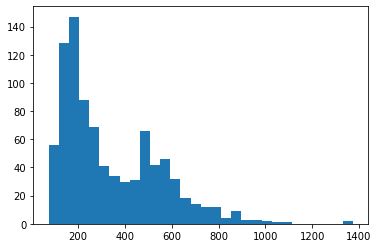

In [30]:
plt.hist(df.wordcount, density=False, bins=30)

(array([337., 273., 109.,  62.,  28.,  17.,   9.,   4.,   5.,   5.,   2.,
          1.,   0.,   2.,   4.,   2.,   1.,   1.,   2.,   2.,   4.,   1.,
          1.,   2.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([  1. ,   7.6,  14.2,  20.8,  27.4,  34. ,  40.6,  47.2,  53.8,
         60.4,  67. ,  73.6,  80.2,  86.8,  93.4, 100. , 106.6, 113.2,
        119.8, 126.4, 133. , 139.6, 146.2, 152.8, 159.4, 166. , 172.6,
        179.2, 185.8, 192.4, 199. ]),
 <a list of 30 Patch objects>)

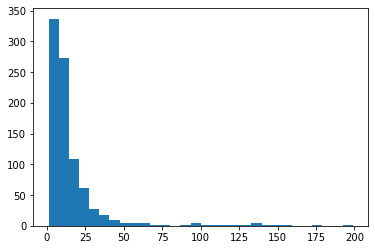

In [224]:
#plt.hist(df.pageviews, density=False, bins=30)
plt.hist(df[df.pageviews <200].pageviews, density=False, bins=30)

# man sieht: die allermeisten Artikel haben 0-50 pageviews, es gibt eber riesige Ausreißer nach oben, wie damit umgehen?

(array([172., 125.,  95.,  68.,  64.,  44.,  39.,  34.,  28.,  21.,  18.,
         18.,   6.,  13.,  14.,  14.,  15.,  12.,   3.,   4.,   6.,   4.,
          6.,   3.,   5.,   6.,   1.,   2.,   3.,   3.]),
 array([   0.        ,  132.26666667,  264.53333333,  396.8       ,
         529.06666667,  661.33333333,  793.6       ,  925.86666667,
        1058.13333333, 1190.4       , 1322.66666667, 1454.93333333,
        1587.2       , 1719.46666667, 1851.73333333, 1984.        ,
        2116.26666667, 2248.53333333, 2380.8       , 2513.06666667,
        2645.33333333, 2777.6       , 2909.86666667, 3042.13333333,
        3174.4       , 3306.66666667, 3438.93333333, 3571.2       ,
        3703.46666667, 3835.73333333, 3968.        ]),
 <a list of 30 Patch objects>)

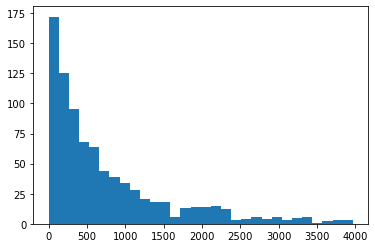

In [225]:
plt.hist(df[df.timeOnPage <4000].timeOnPage, density=False, bins=30)

(array([651., 121.,  30.,  20.,  10.,   9.,  11.,   2.,   4.,   2.,   3.,
          2.,   1.,   1.,   2.,   1.,   2.,   0.,   2.,   0.,   1.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([  0. ,   4.6,   9.2,  13.8,  18.4,  23. ,  27.6,  32.2,  36.8,
         41.4,  46. ,  50.6,  55.2,  59.8,  64.4,  69. ,  73.6,  78.2,
         82.8,  87.4,  92. ,  96.6, 101.2, 105.8, 110.4, 115. , 119.6,
        124.2, 128.8, 133.4, 138. ]),
 <a list of 30 Patch objects>)

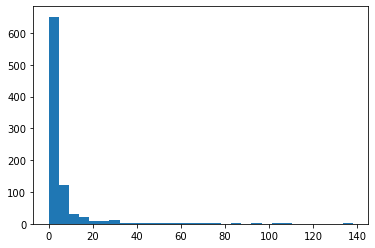

In [226]:
plt.hist(df[df.entrances <150].entrances, density=False, bins=30)

(array([59., 49., 72., 91., 91., 69., 58., 61., 54., 34., 27., 27., 35.,
        18., 24., 11.,  8., 10.,  9., 10.,  6.,  7.,  9.,  5.,  1.,  3.,
         3.,  4.,  2.,  3.]),
 array([  0.        ,  12.95555556,  25.91111111,  38.86666667,
         51.82222222,  64.77777778,  77.73333333,  90.68888889,
        103.64444444, 116.6       , 129.55555556, 142.51111111,
        155.46666667, 168.42222222, 181.37777778, 194.33333333,
        207.28888889, 220.24444444, 233.2       , 246.15555556,
        259.11111111, 272.06666667, 285.02222222, 297.97777778,
        310.93333333, 323.88888889, 336.84444444, 349.8       ,
        362.75555556, 375.71111111, 388.66666667]),
 <a list of 30 Patch objects>)

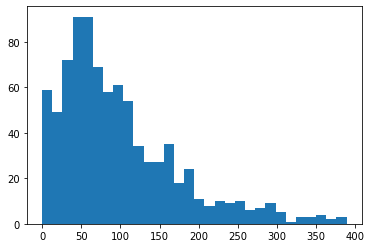

In [246]:
plt.hist(df[df.avgTimeOnPage <400].avgTimeOnPage, density=False, bins=30)

(array([323., 330., 127.,  46.,  18.,   8.,   6.,   7.,   5.,   5.,   1.,
          5.,   2.,   1.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.22575758, 0.45151515, 0.67727273, 0.9030303 ,
        1.12878788, 1.35454545, 1.58030303, 1.80606061, 2.03181818,
        2.25757576, 2.48333333, 2.70909091, 2.93484848, 3.16060606,
        3.38636364, 3.61212121, 3.83787879, 4.06363636, 4.28939394,
        4.51515152, 4.74090909, 4.96666667, 5.19242424, 5.41818182,
        5.64393939, 5.86969697, 6.09545455, 6.32121212, 6.5469697 ,
        6.77272727]),
 <a list of 30 Patch objects>)

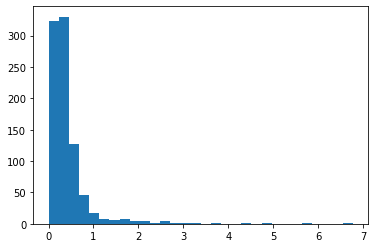

In [73]:
plt.hist(df['avgTimeOnPage/wordcount'], density=False, bins=30)

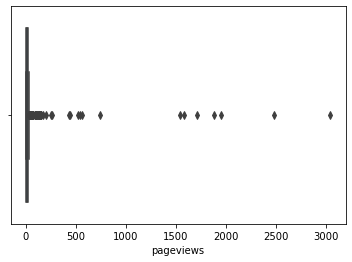

In [227]:
import seaborn as sns
sns.boxplot(x=df.pageviews)

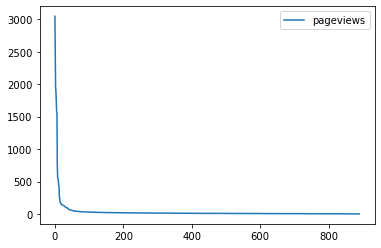

In [77]:
# sorted to see it better
#plt.plot(df.sort_values(by=['timeOnPage'], ascending = False).timeOnPage.to_numpy(), label = 'timeOnPage')
plt.plot(df.sort_values(by=['pageviews'], ascending = False).pageviews.to_numpy(), label = 'pageviews')
plt.legend()

## inspecting avgTimeOnPage

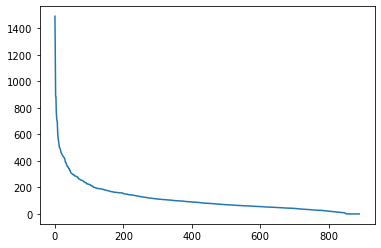

In [238]:
plt.plot(df.sort_values(by=['avgTimeOnPage'], ascending = False).avgTimeOnPage.to_numpy(), label = 'avgTimeOnPage')

In [280]:
df.sort_values(by=['avgTimeOnPage'], ascending = False).head(10)

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,...,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,avgTimeOnPage/wordcount
articleId,,,,,,,,,,,,,,,,,,,,,
51076807,2,2,1,1,1490,,1490.000000,50.000000,100.000000,50.000000,...,,220,vm,Stuttgart,Damit Kinder den Schulbus sicher nutzen können...,217,5.672811,27,6,6.772727
48885655,4,1,3,1,1240,,1240.000000,25.000000,25.000000,25.000000,...,,374,vm,Berlin,Der Auris ist bei Toyota ein zwölfjähriges Int...,380,5.457895,24,5,3.315508
49439597,7,4,5,3,1786,,893.000000,28.571429,57.142857,42.857143,...,,492,vm,Berlin/Münster,Denise Jung wollte nach dem Abitur eigentlich ...,504,6.031746,23,7,1.815041
50484927,2,0,0,0,1762,,881.000000,100.000000,0.000000,0.000000,...,,156,vm,Hamburg,Trotz Corona-Krise darf es Eltern nicht unters...,153,6.803922,30,8,5.647436
49614985,9,7,7,7,1550,,775.000000,22.222222,77.777778,77.777778,...,,295,vm,Berlin,"Jeder Einzelne kann in seinem Alltag helfen, d...",303,5.881188,28,5,2.627119
49439573,9,8,7,6,1444,,722.000000,22.222222,88.888889,66.666667,...,,163,vm,Berlin,"Welchem Hobby ein Mieter nachgeht, muss Vermie...",160,6.068750,0,7,4.429448
49320131,8,3,5,2,2123,,707.666667,37.500000,37.500000,25.000000,...,,148,vm,Hamburg,Das Trockenwerden ist für Eltern ein hochemoti...,149,5.187919,31,8,4.781532
50397041,6,0,3,0,2071,,690.333333,50.000000,0.000000,0.000000,...,,262,vm,München,"Kein Bussi auf dem Gipfel, im Rucksack Mundsch...",258,6.155039,26,9,2.634860
49697877,6,1,3,1,1850,,616.666667,50.000000,16.666667,16.666667,...,,318,vm,Köln,"Köln (dpa/tmn) - So schön die Sommersonne ist,...",327,5.626911,25,9,1.939203


In [99]:
# just take articles with >= 10 pageviews and with ...
df_cut = df.loc[(df['pageviews'] >= 10) ]
#                & (df['avgTimeOnPage/wordcount'] <= 1)
#                & (df['avgTimeOnPage/wordcount'] >= 0.1)]

In [100]:
df_cut

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,genre,geoArea,keywords,links,subject,teaser,text,titelH1,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_sentences,mean_sentence_length,avgTimeOnPage/wordcount,pageviews-exits
articleId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48620281,21,7,12,7,1012,,112.444444,42.857143,33.333333,33.333333,ratgeber,gesundheit,,die-richtigen-schuhe-fuers-joggen,https://www.aachener-zeitung.de/ratgeber/gesun...,200110-99-421545,dpacat:vm,"Fragen & Antworten__,__Fragen und Antworten",Deutschland,"Ratgeber__,__Joggen__,__Laufschuhe__,__Messen_...",,"Gesundheit__,__Sport__,__Medizin__,__Freizeit","Wer ein bisschen durch den Park rennen möchte,...",München/Stuttgart (dpa/tmn) - Frische Luft und...,Ohne Treter läuft nichts: Die richtigen Schuhe...,,769,vm,München/Stuttgart,Frische Luft und Bewegung: Diese Kombination r...,796,5.359296,29,9,52.0,15.307692,0.146222,9
48620381,19,6,11,5,1484,,185.500000,42.105263,31.578947,26.315789,ratgeber,gesundheit,,wann-ist-der-winter-blues-eine-depression,https://www.aachener-zeitung.de/ratgeber/gesun...,200122-99-580227,dpacat:vm,KORR-Bericht,Deutschland,"Ratgeber__,__Psychologie__,__Depressionen__,__...",Info-Telefon Depression,"Gesundheit__,__Medizin","Ewig grauer Himmel, Nässe, Kälte. Je länger de...",Berlin/Frankfurt/Main (dpa/tmn) - Der Wecker k...,Ohne Antrieb: Wann ist der Winter-Blues eine D...,,441,vm,Berlin/Frankfurt/Main,"Der Wecker klingelt, aufstehen! Doch gerade im...",452,5.938053,33,8,28.0,16.142857,0.420635,8
48623085,32,9,20,9,974,,81.166667,37.500000,28.125000,28.125000,ratgeber,bauen-wohnen,,die-besten-spuelmaschinen-multitabs-kosten-sie...,https://www.aachener-zeitung.de/ratgeber/bauen...,200128-99-665065,dpacat:vm,Zusammenfassung,Deutschland,"Ratgeber__,__Stiftung Warentest__,__Spülmaschinen",Ergebnisse Spülmaschinentabs-Test Stiftung War...,"Immobilien__,__Wohnen__,__Verbraucher__,__Umwelt","Dosierfach auf, Tab rein, Klappe zu, Maschine ...",Berlin (dpa/tmn) - Spülmaschinentabs sollen kl...,Warentest: Die besten Spülmaschinen-Multitabs ...,,345,vm,Berlin,Spülmaschinentabs sollen kleine Alleskönner se...,367,5.594005,30,7,23.0,15.956522,0.235266,12
48623259,24,2,7,2,3797,,223.352941,70.833333,8.333333,8.333333,ratgeber,lifestyle,,so-schneidet-make-up-beim-warentest-ab,https://www.aachener-zeitung.de/ratgeber/lifes...,200128-99-667871,dpacat:vm,Meldung,Deutschland,"tmn0500__,__Lifestyle__,__Ratgeber__,__Stiftun...",,"Mode__,__Kosmetik",Make-up mit toller Deckkraft und trotzdem natü...,Berlin (dpa/tmn) - Make-up hat heutzutage eine...,Ist das noch natürlich? - Stiftung Warentest p...,,182,vm,Berlin,Make-up hat heutzutage einen Zweck: Es soll da...,183,5.622951,22,8,8.0,22.875000,1.227214,17
48626959,18,3,10,3,761,,95.125000,44.444444,16.666667,16.666667,ratgeber,gesundheit,,die-laufschuh-trends-fuer-die-saison-2020,https://www.aachener-zeitung.de/ratgeber/gesun...,200116-99-504295,dpacat:vm,Zusammenfassung,Deutschland,"Ratgeber__,__Laufen__,__Joggen__,__Messen__,__...",,"Gesundheit__,__Verbraucher__,__Sport","Dämpfen, stützen, federn: Die Technik in den L...",München (dpa/tmn) - Wie gut sie passen und wie...,Rebound und Algenschaum: Die Laufschuh-Trends ...,,679,vm,München,Wie gut sie passen und wie komfortabel sie sic...,687,5.710335,29,9,49.0,14.020408,0.140096,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51535141,32,29,31,29,10,,10.000000,3.125000,90.625000,90.625000,ratgeber,bildung-beruf,arbeitsplatz-kollegen-rivalitaet-als-ansporn_a...,arbeitsplatz-kollegen-rivalitaet-als-ansporn,https://www.aachener-zeitung.de/zva/amp-gtm.ht...,200602-99-279192,dpacat:vm,KORR-Bericht,Deutschland,"Beruf__,__Ratgeber__,__Karriere__,__Psychologi...",,Arbeit,"Schn

In [101]:
df_cut_sorted = df_cut.sort_values(by = ['stickiness'], ascending = False)
df_cut_sorted

,pageviews,entrances,exits,bounces,timeOnPage,conversions,avgTimeOnPage,stickiness,entranceRate,bounceRate,kategorie,rubrik,subRubrik,titel,pagePath,dpaGuid,categoryCode,genre,geoArea,keywords,links,subject,teaser,text,titelH1,titelH3,wordcount,category,city,text_preprocessed,nr_tokens,mean_token_length,nr_tokens_teaser,nr_tokens_titelH1,nr_sentences,mean_sentence_length,avgTimeOnPage/wordcount,pageviews-exits
articleId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
49989819,11,0,0,0,461,,41.909091,100.000000,0.000000,0.000000,ratgeber,bauen-wohnen,,die-einfachste-laien-loesung-ist-die-schraube,https://www.aachener-zeitung.de/ratgeber/bauen...,200407-99-617848,dpacat:vm,Meldung,Deutschland,"Ratgeber__,__Bauen__,__DIY__,__Heimwerken__,__...",,Immobilien,Sie wollen sich zu Hause der einen und anderen...,Hamburg (dpa/tmn) - An die Elektrotechnik im H...,Lose Steckdose: Die einfachste Laien-Lösung is...,,124,vm,Hamburg,An die Elektrotechnik im Haus sollten sich Lai...,122,5.918033,24,8,8.0,15.250000,0.337977,11
51299425,23,0,1,0,2339,,106.318182,95.652174,0.000000,0.000000,ratgeber,bauen-wohnen,,der-endgegner-beim-hausputz-tipps-gegen-staub,https://www.aachener-zeitung.de/ratgeber/bauen...,200518-99-102572,dpacat:vm,KORR-Bericht,Deutschland,"#gutenews__,__Wohnen__,__Ratgeber__,__Putzen__...",,Immobilien,Putzen ist nicht Ihre Lieblingsbeschäftigung? ...,Düsseldorf (dpa/tmn) - Staub gilt als lästig. ...,Der Endgegner beim Hausputz: Tipps gegen Staub,,446,vm,Düsseldorf,Staub gilt als lästig. Trotzdem befassen wir u...,464,5.818966,29,7,30.0,15.466667,0.238382,22
48675533,13,0,1,0,1131,,94.250000,92.307692,0.000000,0.000000,ratgeber,bauen-wohnen,,kuehlschrank-um-zwei-grad-hochregeln-spart-zeh...,https://www.aachener-zeitung.de/ratgeber/bauen...,200131-99-715521,dpacat:vm,Meldung,Deutschland,"Wohnen__,__Ratgeber__,__Verbraucher__,__Finanz...",,Immobilien,"Es kann so einfach sein, Strom und damit CO2 z...",Berlin (dpa/tmn) - Sieben Grad Innentemperatur...,Kühlschrank um zwei Grad hochregeln spart zehn...,,105,vm,Berlin,Sieben Grad Innentemperatur reichen für einen ...,104,5.730769,20,9,7.0,14.857143,0.897619,12
49843235,13,2,1,1,1004,,83.666667,92.307692,15.384615,7.692308,ratgeber,auto,,was-man-zur-neuen-hu-frist-wissen-muss,https://www.aachener-zeitung.de/ratgeber/auto/...,200331-99-535077,dpacat:vm,"Fragen & Antworten__,__Fragen und Antworten",Deutschland,"Auto__,__Recht__,__Ratgeber__,__Versicherungen...","Empfehlungen des Verkehrsministeriums, pdf__,_...",Verkehr,Wer denkt angesichts der Corona-Krise noch an ...,Berlin (dpa/tmn) - Vier statt zwei Monate: Aut...,Plakette abgelaufen: Was man zur neuen HU-Fris...,,378,vm,Berlin,Vier statt zwei Monate: Autofahrer sollen in d...,379,5.633245,26,9,31.0,12.225806,0.221340,12
49010313,13,3,1,1,2269,,189.083333,92.307692,23.076923,7.692308,ratgeber,familie,,ueber-welches-lob-sich-kinder-freuen,https://www.aachener-zeitung.de/ratgeber/famil...,200217-99-947176,dpacat:vm,Meldung,Deutschland,"Kinder__,__Eltern__,__Ratgeber__,__Erziehung__...",,Familie,Gut gemacht! Ein lobendes Wort der Eltern läss...,Hamburg (dpa/tmn) - Es kann ja wohl nicht so ...,Keine Vorwürfe: Über welches Lob sich Kinder f...,,174,vm,Hamburg,"Es kann ja wohl nicht so schwer sein, ein Kind...",185,4.859459,28,8,11.0,16.818182,1.086686,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50267521,18,14,17,13,70,,70.000000,5.555556,77.777778,72.222222,ratgeber,bildung-beruf,,so-bleiben-sie-motiviert-beim-lernen,https://www.aachener-zeitung.de/ratgeber/bildu...,200427-99-847530,dpacat:vm,KORR-Bericht,Deutschland,"Bildung__,__Ratgeber__,__Familie__,__Eltern__,...",,Arbeit,Das Homeschooling dauert für viele Jahrgänge n...,Mannheim/Hamburg (dpa/tmn) - Die Corona-Pandem...,«Einen Hänger haben» ist okay: Motiviert bleib...,,486,vm,Mannheim/Hamburg,Mannheim/Hamburg (dpa/tmn) - Die Corona-Pandem...,513,5.526316,31,11,28.0,18.321429,0.144

In [91]:
for i in [0,1,2,3,4,5,400,401,402]:
    print(df_cut_sorted.iloc[i]['pageviews-exits'])
    print(df_cut_sorted.iloc[i]['avgTimeOnPage/wordcount'])
    print(df_cut_sorted.iloc[i].text_preprocessed)

9
2.6491963661774967
Ab der dritten Klasse geht es in der Schule los mit Referaten. Manchen Kindern fällt es aber schwer, einen Vortrag vor der Klasse abzuliefern. Wer das mit dem Kind übt, sollte es darin bestärken, dass in der Kürze die Würze liegt, rät die Zeitschrift «Eltern Family» (Ausgabe 3/2020). Um bei Mitschülern und Lehrer gut anzukommen, sei nicht entscheidend, was man alles erzählt, sondern was sich die Zuhörer merken konnten. Ein guter Kniff dabei sei, einen verblüffenden Wissensbaustein zu beleuchten. Dabei dürften Mama und Papa ruhig helfen. Für die Vorbereitung auf das Referat heiße es, das Thema nicht zu groß zu fassen und genug Zeit für die Recherche einzuplanen. Gegen das Lampenfieber kurz vor dem Auftritt vor der Klasse helfe ein kleiner Trick: den Stift fallen lassen, um ihn wieder aufheben zu müssen. Danach gehe es sofort besser, erklärt die Zeitschrift. Alternativ funktioniere auch ein Zauberstein in der Hosentasche, den man zwischendurch mal ganz fest drücken k

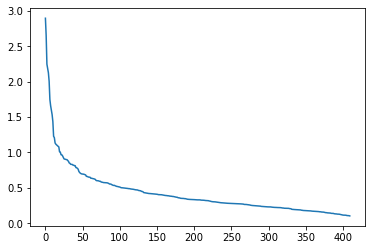

In [51]:
plt.plot(df_cut.sort_values(by=['avgTimeOnPage/wordcount'], ascending = False)['avgTimeOnPage/wordcount'].to_numpy(), label = 'avgTimeOnPage/wordcount')

(array([78., 96., 67., 49., 36., 28., 11., 12.,  9.,  5.,  5.,  2.,  1.,
         0.,  1.,  1.,  2.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
         0.,  1.,  0.,  1.]),
 array([0.10375783, 0.19675757, 0.28975731, 0.38275705, 0.47575678,
        0.56875652, 0.66175626, 0.754756  , 0.84775574, 0.94075548,
        1.03375522, 1.12675496, 1.2197547 , 1.31275444, 1.40575418,
        1.49875391, 1.59175365, 1.68475339, 1.77775313, 1.87075287,
        1.96375261, 2.05675235, 2.14975209, 2.24275183, 2.33575157,
        2.4287513 , 2.52175104, 2.61475078, 2.70775052, 2.80075026,
        2.89375   ]),
 <a list of 30 Patch objects>)

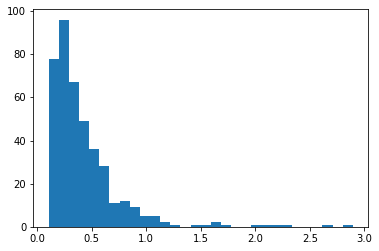

In [42]:
plt.hist(df_cut['avgTimeOnPage/wordcount'], density=False, bins=30)

(array([ 43.,  10.,  15.,  42.,  47.,  29.,  59., 104.,  64.,  72., 143.,
         77.,  91.,  36.,  59.]),
 array([  0.        ,   6.66666667,  13.33333333,  20.        ,
         26.66666667,  33.33333333,  40.        ,  46.66666667,
         53.33333333,  60.        ,  66.66666667,  73.33333333,
         80.        ,  86.66666667,  93.33333333, 100.        ]),
 <a list of 15 Patch objects>)

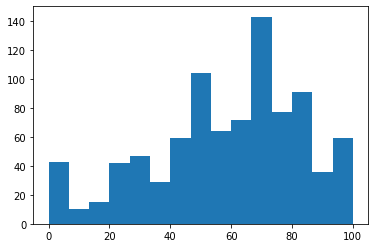

In [103]:
plt.hist(df['stickiness'], density=False, bins=15)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff6a1e86d90>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff6a1e89850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff6a1e86850>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff6a1e91350>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff6a1e91890>],
 'means': []}

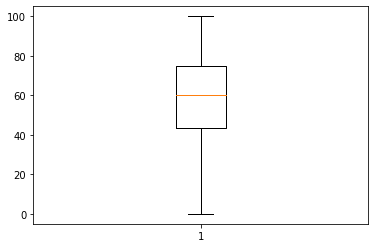

In [106]:
#plt.boxplot(df_cut['avgTimeOnPage/wordcount'])
#plt.boxplot(df_cut['pageviews'])
plt.boxplot(df.stickiness)

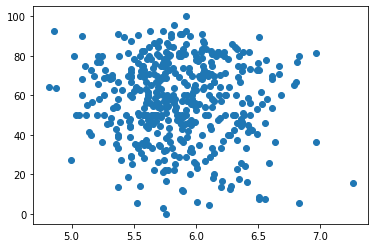

In [108]:
plt.scatter(df_cut.mean_token_length, df_cut.stickiness)

In [109]:
# zeigt TimeOnPage/wordcount aufgespalten nach subject-Kategorien
for s in subjects:
    print(s)
    ids = get_article_ids_that(meta_cat = 'subject', label = s)
    print(np.mean(df.loc[ids]['stickiness']))

Arbeit
38.490602150192146
Automobilindustrie
90.9090909090909
Ernährung
68.10580123944732
Essen und Trinken
67.24310776942355
Familie
59.04797988602787
Finanzen
46.43029617053386
Freizeit
42.8571428571429
Gesundheit
59.59361666709484
Immobilien
65.02493283383171
Kosmetik
70.8333333333333
Medizin
45.78111946532999
Mode
66.61196938593588
Recht
50.0
Sport
43.650793650793645
Steuern
50.0
Technik
44.95526341758852
Tier
56.410256410256395
Tourismus
46.97519931956457
Umwelt
37.5
Verbraucher
49.77506577685232
Verkehr
60.23762525275048
Wohnen
43.75


Kommentar:
* ich glaube: avgTimeOnPage = timeOnPage/(pageviews - exits)
* stickiness = (pageviews-exits)/pageviews (wieviele der Besucher bleiben beim publisher?)